### Load dataset

In [1]:
import pandas as pd

df = pd.read_csv("data/selected_data.csv")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

def replace_class_label(label):
    if label == "Bürgerschaftliches Engagement, Bürgerbeteiligung":
        return "Bürgerbeteiligung"
    elif label == "Kirchen, Religions-, Weltanschauungsgemeinschaften":
        return "Religion"
    else:
        return label
df["Politikbereich"] = df["Politikbereich"].apply(replace_class_label)

all_original_classes = df["Politikbereich"].unique()
       
# df.head(5)

### Combine minority classes

In [2]:
tmp_df = df.groupby(["Politikbereich"]).count().sort_values(by="Zweck", ascending = False).reset_index()
# display(tmp_df)

minority_classes = tmp_df[tmp_df["Zweck"] < 5]["Politikbereich"].values
# display(df[df["Politikbereich"].isin(minority_classes)].sort_values(by=["Politikbereich"]))

df["Politikbereich"] = df["Politikbereich"].apply(lambda s: "Sonstiges" if s in minority_classes else s)
# display(df.groupby(["Politikbereich"]).count().sort_values(by="Zweck", ascending = False).reset_index())

### Get classes list (used later for plotting confusion matrix)

In [3]:
tmp_df = df.groupby(["Politikbereich"]).count().sort_values(by="Zweck", ascending = False).reset_index()

# Used for plotting the confusion matrix
all_selected_ordered_classes = tmp_df["Politikbereich"].values

### Split dataset, create training and testing sets (CV = 10)

In [4]:
from lib.utils.helper_functions import custom_train_test_split

X_train_dfs, X_test_dfs, y_train_dfs, y_test_dfs = custom_train_test_split(df, index = None, cv = 10)

### Functions for training set augmentation

#### Add all classes labels as training examples

In [5]:
def add_class_labels_as_training_examples(X_train, y_train):
    for Politikbereich in all_original_classes:
        if Politikbereich in y_train["Politikbereich"].values:
            X_train = pd.concat([X_train,pd.DataFrame({"Zweck": [Politikbereich]})],ignore_index=True)
            y_train = pd.concat([y_train,pd.DataFrame({"Politikbereich": [Politikbereich]})],ignore_index=True)
        else:
            X_train = pd.concat([X_train,pd.DataFrame({"Zweck": [Politikbereich]})],ignore_index=True)
            y_train = pd.concat([y_train,pd.DataFrame({"Politikbereich": ["Sonstiges"]})],ignore_index=True)
    return X_train, y_train

#### Add examples by inserting or substituting words using BERT contextual word embeddings

In [6]:
import nlpaug.augmenter.word as naw

aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-german-cased', action="insert")
aug_substitute = naw.ContextualWordEmbsAug(model_path='bert-base-german-cased', action="substitute")

def augmentate_training_examples(X_train, y_train, generate_up_to=5):
    full_tmp_df = pd.concat([X_train,y_train],axis=1)
    tmp_df = full_tmp_df.groupby(["Politikbereich"]).count().sort_values(by="Zweck", ascending = False).reset_index()
    max = tmp_df["Zweck"].max()
    tmp_df["missing"] = tmp_df["Zweck"].apply(lambda n: generate_up_to if (max-n)>generate_up_to else max-n)

    augmented_text = []
    politikbereiche = []

    for Politikbereich, missing in zip(tmp_df["Politikbereich"].values, tmp_df["missing"].values):
        original_sentences = full_tmp_df[full_tmp_df["Politikbereich"]==Politikbereich]["Zweck"].values
        original_sentences_size = original_sentences.size - 1
        for i in range(missing):
            if i % 2 == 0:
                augmented_text.append(aug_insert.augment(original_sentences[round(i/missing*original_sentences_size)]))
            else:
                augmented_text.append(aug_substitute.augment(original_sentences[round(i/missing*original_sentences_size)]))
            politikbereiche.append(Politikbereich)
    
    new_data = pd.DataFrame(list(augmented_text), columns=["Zweck"])
    X_train = pd.concat([X_train,new_data],ignore_index=True)
    new_data = pd.DataFrame(list(politikbereiche), columns=["Politikbereich"])
    y_train = pd.concat([y_train,new_data],ignore_index=True)

    return X_train, y_train

# tmp_df = pd.concat([X_train,y_train],axis=1)
# tmp_df[full_tmp_df["Politikbereich"]=="Pflege"]

### Preprocessing functions (data cleaning)

In [7]:
import re
import spacy
from lib.charsplit.splitter import Splitter

class CleanText():
    def remove_digits(self, text):
        # Remove mid slash and digits
        text = re.sub(r'-', ' ', text)
        text = re.sub(r'\d+', '', text)
        return text

    def replace_abbreviations(self, text):
        # Custom ones not supported by spacy
        text = re.sub(r'Abs\.', 'Absatz', text)
        text = re.sub(r'e\.V\.', 'eingetragener Verein', text)
        text = re.sub(r'co\.', 'Kompanie', text)
        text = re.sub(r'Co\.', 'Kompanie', text)
        text = re.sub(r'gem\.', 'gemäß', text)
        text = re.sub(r"'s", '', text)
        return text

    def __call__(self, X, remove_digits = True, replace_abbreviations = True):
        if remove_digits:
            X = X["Zweck"].apply(self.remove_digits)
            X = pd.DataFrame(X.values.tolist(), columns = ["Zweck"])
        if replace_abbreviations:
            X = X["Zweck"].apply(self.replace_abbreviations)
            X = pd.DataFrame(X.values.tolist(), columns = ["Zweck"])
        return X

class SpacyPreprocessor():
    def __init__(self):
        self.nlp = spacy.load("de_core_news_lg")
        self.nlp.remove_pipe("ner")
        self.nlp.remove_pipe("parser")
        self.nlp.remove_pipe("attribute_ruler")
        self.splitter = Splitter()

    def split_compound_word(self, word):
        score, word1, word2 = self.splitter.split_compound(word)[0]
        if score > 0.7:
            word = " ".join([word1, word2])
            # word = " ".join([self.split_compound_word(word1), self.split_compound_word(word2)])
        return word

    def normalize(self, text, remove_punctuation, remove_stopwords,
                            remove_spaces, split_compound_words,
                            lemmatize):
        doc = self.nlp(text)
        output = []
        for token in doc:
            if remove_punctuation and token.is_punct:
                continue
            if remove_stopwords and token.is_stop:
                continue
            if remove_spaces and token.is_space:
                continue
            if split_compound_words and token.pos_ == 'NOUN':
                word = self.split_compound_word(token.text)
            elif lemmatize:
                word = token.lemma_
            else:
                word = token.text
            
            output.append(word)
        
        return " ".join(output)

    def __call__(self, X, remove_punctuation = True, remove_stopwords = False,
                            remove_spaces = True, split_compound_words = True,
                            lemmatize = False):
        X = X["Zweck"].apply(lambda text: self.normalize(text,
                                                            remove_punctuation,
                                                            remove_stopwords,
                                                            remove_spaces,
                                                            split_compound_words,
                                                            lemmatize))
        X = pd.DataFrame(X.values.tolist(), columns = ["Zweck"])
        return X

text_cleaner_preprocessor = CleanText()
spacy_preprocessor = SpacyPreprocessor()

### BERT sentence embedding preprocessor

In [8]:
%%capture

import torch
from transformers import BertModel, BertTokenizer
from lib.bert_pytorch.helper_functions import get_device

class BertSentenceEmbeddigs():
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
        self.device = get_device()
        self.model = BertModel.from_pretrained('bert-base-german-cased', 
                                                output_hidden_states=True)\
                                                    .to(self.device)
        self.model.eval()
    def embed_sentence(self, sentence: str):
        ids_tensor = self.tokenizer.encode(sentence, return_tensors='pt')
        ids_tensor = ids_tensor.to(self.device)
        with torch.no_grad():
            out = self.model(input_ids=ids_tensor)
        hidden_states = out.hidden_states
        last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]
        sentence_embedding = torch.cat(tuple(last_four_layers), dim=0)
        sentence_embedding = torch.mean(sentence_embedding, dim=0)
        sentence_embedding = torch.mean(sentence_embedding, dim=0)
        return sentence_embedding.cpu().numpy()
    def __call__(self, X):
        X = X["Zweck"].apply(self.embed_sentence)
        X = pd.DataFrame(X.values.tolist())
        return X

bert_embedder = BertSentenceEmbeddigs()

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### MLP classifier

In [9]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(solver="sgd",
                            learning_rate="adaptive",
                            learning_rate_init=0.01,
                            activation="relu",
                            hidden_layer_sizes=(768,384,192,),
                            random_state=42,
                            # early_stopping=True,
                            # validation_fraction=0.1,
                            max_iter=500)

### Execute preprocessing, training loop, and evaluation on validation set for each fold in CV=10

In [10]:
%%capture

y_pred = []

for fold in range(10):
    X_train, y_train = X_train_dfs[fold].copy(), y_train_dfs[fold].copy()
    X_test, _ = X_test_dfs[fold].copy(), y_test_dfs[fold].copy()
    X_train, y_train = add_class_labels_as_training_examples(X_train, y_train)
    X_train, y_train = augmentate_training_examples(X_train, y_train, generate_up_to=5)
    # X_train = text_cleaner_preprocessor(X_train, 
    #                                     remove_digits = False, 
    #                                     replace_abbreviations = False)
    # X_train = spacy_preprocessor(X_train, 
    #                             remove_punctuation = False,
    #                             remove_stopwords = False,
    #                             remove_spaces = False,
    #                             split_compound_words = False,
    #                             lemmatize = False)
    X_train = bert_embedder(X_train)
    X_test = bert_embedder(X_test)

    classifier.fit(X_train, y_train.values.ravel())

    y_pred.append(classifier.predict(X_test))

### Evaluate model performance (macro-F1, weighted-F1 and confusion matrix)

In [11]:
from sklearn.metrics import f1_score

print (f"PERFORMANCE ON TEST DATA:")
avg_macro = 0
avg_weighted = 0

for fold in range(10):
    macro_f1 = f1_score(y_test_dfs[fold], y_pred[fold], average='macro')
    weighted_f1 = f1_score(y_test_dfs[fold], y_pred[fold], average='weighted')
    
    avg_macro += macro_f1
    avg_weighted += weighted_f1

    print (f"fold = {fold+1}\tmacro_f1 = {macro_f1:.2f}\tweighted_f1 = {weighted_f1:.2f}")

print(f"\navg_macro = {avg_macro/10:.2f}\tavg_weighted = {avg_weighted/10:.2f}")

PERFORMANCE ON TEST DATA:
fold = 1	macro_f1 = 0.25	weighted_f1 = 0.57
fold = 2	macro_f1 = 0.46	weighted_f1 = 0.63
fold = 3	macro_f1 = 0.15	weighted_f1 = 0.46
fold = 4	macro_f1 = 0.47	weighted_f1 = 0.70
fold = 5	macro_f1 = 0.45	weighted_f1 = 0.68
fold = 6	macro_f1 = 0.54	weighted_f1 = 0.74
fold = 7	macro_f1 = 0.50	weighted_f1 = 0.71
fold = 8	macro_f1 = 0.34	weighted_f1 = 0.58
fold = 9	macro_f1 = 0.45	weighted_f1 = 0.68
fold = 10	macro_f1 = 0.38	weighted_f1 = 0.64

avg_macro = 0.40	avg_weighted = 0.64


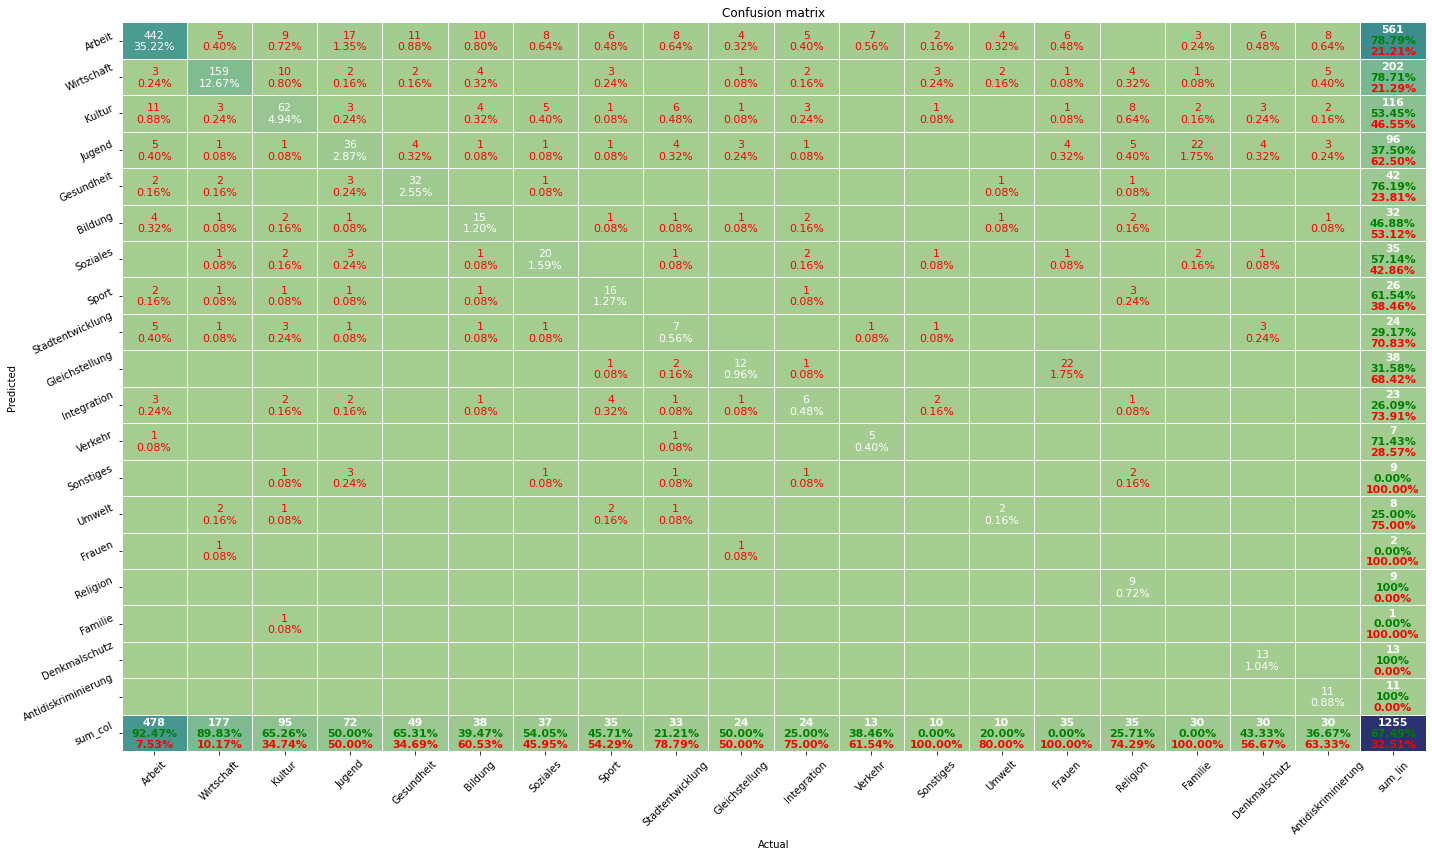

In [12]:
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix

if len(y_pred) == 10:
    ypred = [pd.DataFrame(array, columns=["Politikbereich"]) for array in y_pred]

cf_matrix = confusion_matrix(   pd.concat(y_test_dfs, ignore_index=True),
                                pd.concat(ypred, ignore_index=True),
                                labels=all_selected_ordered_classes)
df_cm = pd.DataFrame(cf_matrix,
                        index=all_selected_ordered_classes,
                        columns=all_selected_ordered_classes)
pp_matrix(df_cm, figsize=(20,12), cmap="crest", fz=11)

### Evaluate model on test data

In [13]:
# import pandas as pd

# test_df = pd.read_csv("data/test_data.csv")
# X_test = df.loc[:, df.columns != 'Politikbereich']

In [14]:
# X_train, y_train = df.loc[:, df.columns != 'Politikbereich'], df.loc[:,df.columns == 'Politikbereich']

# X_train, y_train = add_class_labels_as_training_examples(X_train, y_train)
# X_train, y_train = augmentate_training_examples(X_train, y_train, generate_up_to=5)

# # X_train = text_cleaner_preprocessor(X_train)
# # X_train = spacy_preprocessor(X_train)

# X_train = bert_embedder(X_train)

# classifier.fit(X_train, y_train.values.ravel())


# X_test = text_cleaner_preprocessor(X_test)
# X_test = spacy_preprocessor(X_test)
# X_test = bert_embedder(X_test)

# classifier.predict(X_test)